In [30]:
#!/usr/bin/env python
# coding: utf-8

import sys
sys.dont_write_bytecode = True

import time
import numpy as np  
import pandas as pd
import datetime
import graphviz
import gurobipy as gp
from gurobipy import GRB
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
import matplotlib.pyplot as plt
import argparse
from pprint import pprint

import time_stitching as tst

OUTPUT_DIR = "./optimizer_output/"

random.seed(1234)

VERBOSITY=1
DELIMITER="#"

timestamp_list = list()
temp_timestamp_list = list()
def LOG_TIMESTAMP(event_name):
    timestamp_list.append([event_name, time.time()])
    if len(timestamp_list) > 1:
        print("Finished, " + event_name + ", duration, " + str(round(timestamp_list[-1][1] - timestamp_list[-2][1], 5)))

def TEMP_LOG_TIMESTAMP(event_name):
    temp_timestamp_list.append([event_name, time.time()])
    if len(temp_timestamp_list) > 1:
        print("Finished, " + event_name + ", duration, " + str(round(timestamp_list[-1][1] - timestamp_list[-2][1], 5)))
        
def prettyprint_timestamp():
    print()
    print("*"*30)
    print("** timestamp_list(ms)")
    for i in range(1, len(timestamp_list)):
        print(timestamp_list[i][0], end=",")
    print()    

def print_timestamp():
    for i in range(1, len(timestamp_list)):
        print(round((timestamp_list[i][1] - timestamp_list[i-1][1]), 5), end=",")
    print()
    # print("*"*30)
        
def print_log(msg, obj=None):
    if VERBOSITY >= 1:
        if obj == None:
            print("[LOG] ", end="")
            print(msg)
        else:
            print("[LOG] ", end="")
            print(msg, obj)
        
def print_error(msg):
    exit_time = 5
    print("[ERROR] " + msg)
    print("EXIT PROGRAM in")
    for i in reversed(range(exit_time)) :
        print("{} seconds...".format(i))
        time.sleep(1)
    exit()

def calc_num_svc_of_general_tree(flags):
    def calc_num_svc_within_depth(fod, nochild, dep):
        if dep == 0 or dep == 1:
            return 1
        proliferation_degree = fod - nochild
        return pow(proliferation_degree, dep-2) * fod
    num_svc = list()
    for d in range(flags.depth):
        num_svc.append(calc_num_svc_within_depth(flags.fan_out_degree, flags.no_child_constant, d))
    print("num svc in each depth: ", num_svc)
    print("total num svc per cluster: ", sum(num_svc))

def argparse_add_argument(parser):
    def list_of_ints(arg):
        return list(map(int, arg.split(',')))
    parser.add_argument("--routing_algorithm", type=str, default="SLATE", choices=["LCLB", "MCLB", "heuristic_TE", "SLATE"])
    parser.add_argument("--NUM_CLUSTER", type=int, default=2)
    parser.add_argument('--NUM_REQUEST', type=list_of_ints, default=None)
    parser.add_argument("--regressor_degree", type=int, default=1)
    
def check_argument(flags):
    assert len(flags.NUM_REQUEST) == flags.NUM_CLUSTER
    
def print_argument(flags):
    print_log("=============================================================")
    print_log("======================= argument ============================")
    print_log("=============================================================")
    for key, value in vars(flags).items():
        print_log("** {}: {}".format(key, str(value)))
    print_log("=============================================================")
    
    
LOG_TIMESTAMP("main function start")
parser = argparse.ArgumentParser()
argparse_add_argument(parser)
flags, unparsed = parser.parse_known_args()
if flags.NUM_REQUEST == None:
    flags.NUM_REQUEST = list()
    # for _ in range(flags.NUM_CLUSTER):
    flags.NUM_REQUEST.append(5000)
    flags.NUM_REQUEST.append(10000)
print_argument(flags)
check_argument(flags)
LOG_TIMESTAMP("argparse")

[LOG] =============================================================
[LOG] ======================= argument ============================
[LOG] =============================================================
[LOG] ** routing_algorithm: SLATE
[LOG] ** NUM_CLUSTER: 2
[LOG] ** NUM_REQUEST: [5000, 10000]
[LOG] ** regressor_degree: 1
[LOG] =============================================================
Finished, argparse, duration, 0.00111


### Stitch time
- Input: trace log
- Output: traces, dags

In [31]:
# TRACE_LOG_PATH = "./trace_and_load_log.txt"
# TRACE_LOG_PATH = "./call-logs-sept-13.txt"
traces, graph_dict, unique_dags = tst.stitch_time(tst.LOG_PATH)

[LOG] time stitching starts
[LOG] svc name,reviews-v3, load per tick,16
[LOG] svc name,details-v1, load per tick,81
[LOG] svc name,reviews-v1, load per tick,20
[LOG] svc name,productpage-v1, load per tick,96
[LOG] svc name,ratings-v1, load per tick,45
[LOG] svc name,reviews-v2, load per tick,25
[LOG] svc name,reviews-v3, load per tick,31
[LOG] svc name,reviews-v1, load per tick,29
[LOG] svc name,productpage-v1, load per tick,120
[LOG] svc name,ratings-v1, load per tick,53
[LOG] svc name,reviews-v2, load per tick,27
[LOG] svc name,details-v1, load per tick,80
[LOG] svc name,details-v1, load per tick,38
[LOG] svc name,reviews-v3, load per tick,13
[LOG] svc name,reviews-v1, load per tick,20
[LOG] svc name,productpage-v1, load per tick,25
[LOG] svc name,reviews-v2, load per tick,19
[LOG] svc name,ratings-v1, load per tick,31
weird_span_id:  5
#input trace: 202
#filtered trace: 28
#removed_traces trace: 174
#relative t trace: 28
parent: productpage-v1, child_1:details-v1, child_2: reviews-v

In [32]:
assert len(unique_dags) == 1
unique_services = dict()
only_one_unique_dag = dict()
for _, dag in unique_dags.items():
    tst.print_dag(dag)
    only_one_unique_dag = dag
    unique_services = list(tst.get_unique_svc_names_from_dag(dag).keys())
unique_services

productpage-v1(d8fc0d9d8edc0388)->details-v1(db1760fc78c58bff)
productpage-v1(d8fc0d9d8edc0388)->reviews-v2(34669d6678cb17c7)
reviews-v2(34669d6678cb17c7)->ratings-v1(3d337444c3d30efc)


['productpage-v1', 'details-v1', 'reviews-v2', 'ratings-v1']

### Define compute arc var

***service_name#cluster_id#postfix***

In [33]:
def span_to_compute_arc_var_name(svc_name, cid):
    return (svc_name+DELIMITER+str(cid)+DELIMITER+"start", svc_name+DELIMITER+str(cid)+DELIMITER+"end") # return type: tuple

def spans_to_network_arc_var_name(parent_name, src_cid, child_name, dst_cid):
    if parent_name == "src_*_*":
        src_postfix = "*"
    else:
        src_postfix = "end"
    if child_name == "dst_*_*":
        dst_postfix = "*"
    else:
        dst_postfix = "start"
    src_name = parent_name+DELIMITER+str(src_cid)+DELIMITER+src_postfix
    dst_name = child_name+DELIMITER+str(dst_cid)+DELIMITER+dst_postfix
    return (src_name, dst_name)

In [34]:
svc_name_list = list()
compute_arc_var_name = dict()
per_service_compute_arc = dict()
for svc_name in unique_services:
    for cid in range(flags.NUM_CLUSTER):
        var_name = span_to_compute_arc_var_name(svc_name, cid)
        compute_arc_var_name[var_name] = list()
        if svc_name not in per_service_compute_arc:
            per_service_compute_arc[svc_name] = list()
        per_service_compute_arc[svc_name].append(var_name)
    
LOG_TIMESTAMP("defining compute_arc_var_name")
compute_arc_var_name

Finished, defining compute_arc_var_name, duration, 0.9317


{('productpage-v1#0#start', 'productpage-v1#0#end'): [],
 ('productpage-v1#1#start', 'productpage-v1#1#end'): [],
 ('details-v1#0#start', 'details-v1#0#end'): [],
 ('details-v1#1#start', 'details-v1#1#end'): [],
 ('reviews-v2#0#start', 'reviews-v2#0#end'): [],
 ('reviews-v2#1#start', 'reviews-v2#1#end'): [],
 ('ratings-v1#0#start', 'ratings-v1#0#end'): [],
 ('ratings-v1#1#start', 'ratings-v1#1#end'): []}

### Define network arc var

In [35]:
## Define names of the variables for network arc in gurobi
source_name = "src_*_*"
destination_name = "dst_*_*"
source_node = source_name+DELIMITER+"*"+DELIMITER+"*"
destination_node = destination_name+DELIMITER+"*"+DELIMITER+"*"

'''
network_arc_var_name
- key: tuple(src_node_name, dst_node_name)
- value: request_size_in_bytes
'''
network_arc_var_name = dict()
for parent_span, children in only_one_unique_dag.items():
    # leaf service to dst
    if len(children) == 0: # leaf service
        print(parent_span.svc_name + " is leaf service")
        for src_cid in range(flags.NUM_CLUSTER):
            var_name = spans_to_network_arc_var_name(parent_span.svc_name, src_cid, destination_name, "*")
            if var_name not in network_arc_var_name:
                network_arc_var_name[var_name] = 0
    for child_span in children:
        if parent_span.svc_name == tst.FRONTEND_svc:
            # src to frontend service
            for src_cid in range(flags.NUM_CLUSTER):
                var_name = spans_to_network_arc_var_name(source_name, "*", parent_span.svc_name, src_cid)
                if var_name not in network_arc_var_name:
                    network_arc_var_name[var_name] = parent_span.request_size_in_bytes
                # frontend to service
                for dst_cid in range(flags.NUM_CLUSTER):
                    var_name = spans_to_network_arc_var_name(parent_span.svc_name, src_cid, child_span.svc_name, dst_cid)
                    if var_name not in network_arc_var_name:
                        network_arc_var_name[var_name] = child_span.request_size_in_bytes
        # service to service
        else:
            for src_cid in range(flags.NUM_CLUSTER):
                for dst_cid in range(flags.NUM_CLUSTER):
                    var_name = spans_to_network_arc_var_name(parent_span.svc_name, src_cid, child_span.svc_name, dst_cid)
                    if var_name not in network_arc_var_name:
                        network_arc_var_name[var_name] = child_span.request_size_in_bytes
print(len(network_arc_var_name))
assert len(network_arc_var_name) == 18 # bookinfo, two cluster set up

def check_network_arc_var_name(net_arc_var_n):
    for (src, dst), _ in net_arc_var_n.items():
        src_node = src.split(DELIMITER)[0]
        dst_node = dst.split(DELIMITER)[0]
        src_postfix = src.split(DELIMITER)[-1]
        dst_postfix = dst.split(DELIMITER)[-1]
        if src_node == source_name:
            assert dst_postfix == "start" 
        elif dst_node == destination_name:
            assert src_postfix == "end" 
        else:
            assert src_postfix == "end" 
            assert dst_postfix == "start" 
        
check_network_arc_var_name(network_arc_var_name)
network_arc_var_name

details-v1 is leaf service
ratings-v1 is leaf service
18


{('details-v1#0#end', 'dst_*_*#*#*'): 0,
 ('details-v1#1#end', 'dst_*_*#*#*'): 0,
 ('src_*_*#*#*', 'productpage-v1#0#start'): 10,
 ('productpage-v1#0#end', 'details-v1#0#start'): 10,
 ('productpage-v1#0#end', 'details-v1#1#start'): 10,
 ('src_*_*#*#*', 'productpage-v1#1#start'): 10,
 ('productpage-v1#1#end', 'details-v1#0#start'): 10,
 ('productpage-v1#1#end', 'details-v1#1#start'): 10,
 ('productpage-v1#0#end', 'reviews-v2#0#start'): 10,
 ('productpage-v1#0#end', 'reviews-v2#1#start'): 10,
 ('productpage-v1#1#end', 'reviews-v2#0#start'): 10,
 ('productpage-v1#1#end', 'reviews-v2#1#start'): 10,
 ('ratings-v1#0#end', 'dst_*_*#*#*'): 0,
 ('ratings-v1#1#end', 'dst_*_*#*#*'): 0,
 ('reviews-v2#0#end', 'ratings-v1#0#start'): 10,
 ('reviews-v2#0#end', 'ratings-v1#1#start'): 10,
 ('reviews-v2#1#end', 'ratings-v1#0#start'): 10,
 ('reviews-v2#1#end', 'ratings-v1#1#start'): 10}

### Latency model training (linear regression)

#### Create dataframe of training data

In [36]:
print(len(traces))
print(len(unique_services))
print(len(traces) * len(unique_services))

28
4
112


In [37]:
true_function_degree = 1 # 1: linear, >2: polynomial
regressor_degree = flags.regressor_degree # 1: linear, >2: polynomial

load = list()
compute_time = list()
service_name_ = list()
index_ = list()

for tid, spans in traces.items():
    for svc_name, span in spans.items():
        load.append(span.load)
        compute_time.append(span.xt)
        index_.append(span_to_compute_arc_var_name(span.svc_name, span.cluster_id))
        service_name_.append(span.svc_name)
compute_time_observation = pd.DataFrame(
    data={
        "service_name": service_name_,
        "load": load, 
        "compute_time": compute_time,
    },
    index=index_
)
# with pd.option_context('display.max_rows', None):
display(compute_time_observation)

,service_name,load,compute_time
"(details-v1#0#start, details-v1#0#end)",details-v1,81,0
"(productpage-v1#0#start, productpage-v1#0#end)",productpage-v1,96,307
"(ratings-v1#0#start, ratings-v1#0#end)",ratings-v1,45,0
"(reviews-v2#0#start, reviews-v2#0#end)",reviews-v2,25,10
"(details-v1#1#start, details-v1#1#end)",details-v1,81,0
...,...,...,...
"(details-v1#0#start, details-v1#0#end)",details-v1,80,0
"(details-v1#1#start, details-v1#1#end)",details-v1,38,0
"(productpage-v1#1#start, productpage-v1#1#end)",productpage-v1,25,388
"(reviews-v2#1#start, reviews-v2#1#end)",reviews-v2,19,13


[LOG] Service productpage-v1
[LOG] - Coef: [97.9341929]
[LOG] - R^2: 0.00707
[LOG] Service details-v1
[LOG] - Coef: [-0.]
[LOG] - R^2: 1.0
[LOG] Service reviews-v2
[LOG] - Coef: [1.91973644]
[LOG] - R^2: 0.09861
[LOG] Service ratings-v1
[LOG] - Coef: [-0.]
[LOG] - R^2: 1.0
Finished, train regression model, duration, 1.3012


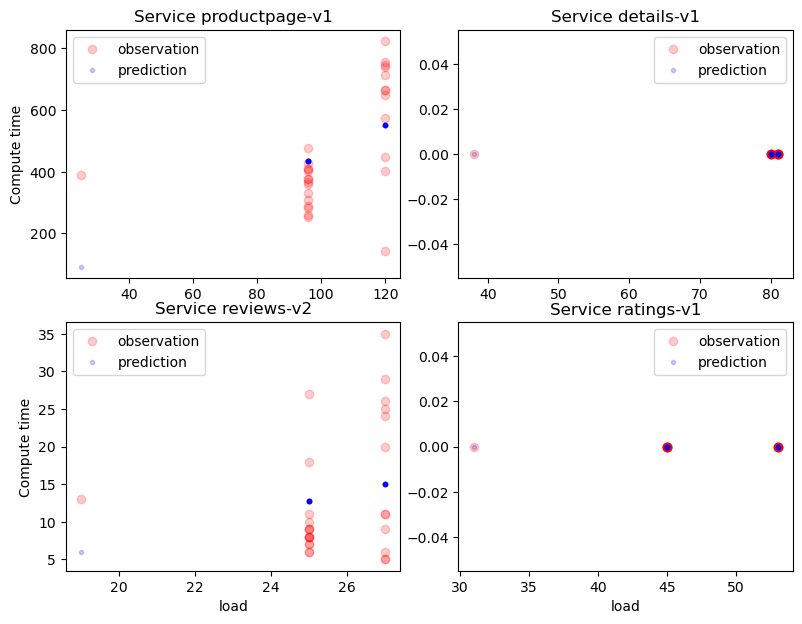

In [38]:
## Per-service load-to-compute time modeling.
idx = 0
num_subplot_row = 2
num_subplot_col = 2
fig, (plot_list) = plt.subplots(num_subplot_row, num_subplot_col, figsize=(8,6))
fig.tight_layout()

max_compute_time = dict()
max_load = dict()
# max_compute_time = dict()
regressor_dict = dict()
for svc_name in unique_services:
    temp_df = compute_time_observation[compute_time_observation["service_name"] == svc_name]
    X = temp_df[["load"]]
    y = temp_df["compute_time"]
    # X = list(temp_df["load"])
    # y = list(temp_df["compute_time"])
    # print("X: ", X["load"])
    # print("y: ", y)
    
    #############################################
    # max_load[svc_name] = max(X["load"])+100
    # max_compute_time[svc_name] = max(y)+1000
    max_load[svc_name] = 1000000
    max_compute_time[svc_name] = 1000000
    #############################################
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, random_state=1
    )
    feat_transform = make_column_transformer(
        (StandardScaler(), ["load"]),
        # ("passthrough", ["load"]),
        verbose_feature_names_out=False,
        remainder='drop'
    )
    if regressor_degree == 1:
        regressor_dict[svc_name] = make_pipeline(feat_transform, LinearRegression())
        regressor_dict[svc_name].fit(X_train, y_train)
    elif regressor_degree > 1:
        poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
        regressor_dict[svc_name] = make_pipeline(feat_transform, poly, LinearRegression())
        regressor_dict[svc_name].fit(X_train, y_train)
        
    ## Run prediction and compare it with the ground truth to see how accurate the trained model is
    y_pred = regressor_dict[svc_name].predict(X_test)
    print_log("Service {}".format(svc_name))
    print_log("- Coef: {}".format(regressor_dict[svc_name]["linearregression"].coef_))
    print_log(f"- R^2: {np.round(r2_score(y_test, y_pred),5)}")

    ## Plot
    row_idx = int(idx/num_subplot_col)
    col_idx = idx%num_subplot_col
    # print(row_idx, col_idx)
    # plot_list[row_idx][col_idx].plot(X["load"], y, 'ro', label="observation", alpha=0.2)
    # plot_list[row_idx][col_idx].plot(X["load"], regressor_dict[svc_name].predict(X), 'b.', label="prediction", alpha=0.2)
    plot_list[row_idx][col_idx].plot(X, y, 'ro', label="observation", alpha=0.2)
    plot_list[row_idx][col_idx].plot(X, regressor_dict[svc_name].predict(X), 'b.', label="prediction", alpha=0.2)
    
    plot_list[row_idx][col_idx].legend()
    plot_list[row_idx][col_idx].set_title("Service " + svc_name)
    if row_idx == num_subplot_row-1:
        plot_list[row_idx][col_idx].set_xlabel("load")
    if col_idx == 0:
        plot_list[row_idx][col_idx].set_ylabel("Compute time")
    idx += 1
    
LOG_TIMESTAMP("train regression model")

### Define network egress cost

In [39]:
network_arc_var_name_list = list(network_arc_var_name.keys())
network_arc_var_name_list
network_arc_var_name

{('details-v1#0#end', 'dst_*_*#*#*'): 0,
 ('details-v1#1#end', 'dst_*_*#*#*'): 0,
 ('src_*_*#*#*', 'productpage-v1#0#start'): 10,
 ('productpage-v1#0#end', 'details-v1#0#start'): 10,
 ('productpage-v1#0#end', 'details-v1#1#start'): 10,
 ('src_*_*#*#*', 'productpage-v1#1#start'): 10,
 ('productpage-v1#1#end', 'details-v1#0#start'): 10,
 ('productpage-v1#1#end', 'details-v1#1#start'): 10,
 ('productpage-v1#0#end', 'reviews-v2#0#start'): 10,
 ('productpage-v1#0#end', 'reviews-v2#1#start'): 10,
 ('productpage-v1#1#end', 'reviews-v2#0#start'): 10,
 ('productpage-v1#1#end', 'reviews-v2#1#start'): 10,
 ('ratings-v1#0#end', 'dst_*_*#*#*'): 0,
 ('ratings-v1#1#end', 'dst_*_*#*#*'): 0,
 ('reviews-v2#0#end', 'ratings-v1#0#start'): 10,
 ('reviews-v2#0#end', 'ratings-v1#1#start'): 10,
 ('reviews-v2#1#end', 'ratings-v1#0#start'): 10,
 ('reviews-v2#1#end', 'ratings-v1#1#start'): 10}

In [40]:
list(network_arc_var_name.keys())

[('details-v1#0#end', 'dst_*_*#*#*'),
 ('details-v1#1#end', 'dst_*_*#*#*'),
 ('src_*_*#*#*', 'productpage-v1#0#start'),
 ('productpage-v1#0#end', 'details-v1#0#start'),
 ('productpage-v1#0#end', 'details-v1#1#start'),
 ('src_*_*#*#*', 'productpage-v1#1#start'),
 ('productpage-v1#1#end', 'details-v1#0#start'),
 ('productpage-v1#1#end', 'details-v1#1#start'),
 ('productpage-v1#0#end', 'reviews-v2#0#start'),
 ('productpage-v1#0#end', 'reviews-v2#1#start'),
 ('productpage-v1#1#end', 'reviews-v2#0#start'),
 ('productpage-v1#1#end', 'reviews-v2#1#start'),
 ('ratings-v1#0#end', 'dst_*_*#*#*'),
 ('ratings-v1#1#end', 'dst_*_*#*#*'),
 ('reviews-v2#0#end', 'ratings-v1#0#start'),
 ('reviews-v2#0#end', 'ratings-v1#1#start'),
 ('reviews-v2#1#end', 'ratings-v1#0#start'),
 ('reviews-v2#1#end', 'ratings-v1#1#start')]

In [41]:
idx = 0
min_load = 0
max_load = sum(flags.NUM_REQUEST)


min_network_egress_cost = list()
max_network_egress_cost = list()

network_arc_var_name_list = list(network_arc_var_name.keys())
for network_arc_var in network_arc_var_name_list:
    src_node = network_arc_var[0]
    dst_node = network_arc_var[1]
    src_svc_name = src_node.split(DELIMITER)[0] # A
    dst_svc_name = dst_node.split(DELIMITER)[0] # B
    if src_svc_name == "src_*_*":
        min_network_egress_cost.append(0)
        max_network_egress_cost.append(0)
    elif dst_svc_name == "dst_*_*":
        min_network_egress_cost.append(0)
        max_network_egress_cost.append(0)
    else:
        try:
            src_cid = int(src_node.split(DELIMITER)[1])
        except:
            print_log(src_svc_name, src_node, src_node.split(DELIMITER))
        try:
            dst_cid = int(dst_node.split(DELIMITER)[1])
        except:
            print_log(dst_svc_name, dst_node, dst_node.split(DELIMITER))
        # local routing
        # no egress charge on local routing
        # if src_cid % flags.NUM_CLUSTER == dst_cid % flags.NUM_CLUSTER:
        if src_cid == dst_cid:
            min_network_egress_cost.append(0) 
            max_network_egress_cost.append(0)
        # remote routing
        else:
            min_network_egress_cost.append(network_arc_var_name[network_arc_var])
            max_network_egress_cost.append(network_arc_var_name[network_arc_var])

network_egress_cost_data = pd.DataFrame(
    data={
        "min_network_egress_cost": min_network_egress_cost,
        "max_network_egress_cost": max_network_egress_cost,
        # "min_load":[min_load]*len(network_arc_var_name_list),
        # "max_load":[max_load]*len(network_arc_var_name_list),
    },
    index=network_arc_var_name_list
    # index=network_arc_var_name
)
network_egress_cost_data

,min_network_egress_cost,max_network_egress_cost
"(details-v1#0#end, dst_*_*#*#*)",0,0
"(details-v1#1#end, dst_*_*#*#*)",0,0
"(src_*_*#*#*, productpage-v1#0#start)",0,0
"(productpage-v1#0#end, details-v1#0#start)",0,0
"(productpage-v1#0#end, details-v1#1#start)",10,10
"(src_*_*#*#*, productpage-v1#1#start)",0,0
"(productpage-v1#1#end, details-v1#0#start)",10,10
"(productpage-v1#1#end, details-v1#1#start)",0,0
"(productpage-v1#0#end, reviews-v2#0#start)",0,0
"(productpage-v1#0#end, reviews-v2#1#start)",10,10


### Define compute cost

In [42]:
min_compute_egress_cost = list()
max_compute_egress_cost = list()
compute_arc_var_name_list = list(compute_arc_var_name.keys())
for src_repl, dst_repl in compute_arc_var_name_list:
    # compute edge does not involve any networking
    min_compute_egress_cost.append(0)
    max_compute_egress_cost.append(0)
                
compute_egress_cost_data = dict()
for svc_name in unique_services:
    compute_egress_cost_data[svc_name] = pd.DataFrame(
        data={
            # "min_load":[min_load] * len(per_service_compute_arc[svc_name]),
            # "max_load":[max_load] * len(per_service_compute_arc[svc_name]),
            "min_compute_egress_cost": [0] * len(per_service_compute_arc[svc_name]),
            "max_compute_egress_cost": [0] * len(per_service_compute_arc[svc_name]),
        },
        index=per_service_compute_arc[svc_name]
    )

## Duplicate
# min_load = 0
# max_load = max(x_load)
compute_time_data = dict()
for svc_name in unique_services:
    compute_time_data[svc_name] = pd.DataFrame(
        data={
            "min_load":[min_load] * len(per_service_compute_arc[svc_name]),
            "max_load":[max_load] * len(per_service_compute_arc[svc_name]),
            "min_compute_time": [0] * len(per_service_compute_arc[svc_name]),
            "max_compute_time": [max_compute_time[svc_name]] * len(per_service_compute_arc[svc_name]),
        },
        index=per_service_compute_arc[svc_name]
    )

### Define network latency

In [43]:
min_network_latency = list()
max_network_latency = list()
for network_arc_var in network_arc_var_name_list:
    src_node = network_arc_var[0]
    dst_node = network_arc_var[1]
    
    src_svc_name = src_node.split(DELIMITER)[0]
    dst_svc_name = dst_node.split(DELIMITER)[0]
    if src_svc_name == "src_*_*":
        min_network_latency.append(0)
        max_network_latency.append(0)
    elif dst_svc_name == "dst_*_*":
        min_network_latency.append(0)
        max_network_latency.append(0)
    else:
        try:
            src_idx = int(src_node.split(DELIMITER)[1])
        except:
            print_error(src_svc_name, src_node.split(DELIMITER))
        try:
            dst_idx = int(dst_node.split(DELIMITER)[1])
        except:
            print_error(dst_svc_name, dst_node.split(DELIMITER))
        # Network latency for local routing
        if src_idx % flags.NUM_CLUSTER == dst_idx % flags.NUM_CLUSTER:
            min_network_latency.append(tst.intra_cluster_network_rtt)
            max_network_latency.append(tst.intra_cluster_network_rtt)
        # Network latency for remote routing
        else:
            min_network_latency.append(tst.inter_cluster_network_rtt)
            max_network_latency.append(tst.inter_cluster_network_rtt)

network_latency_data = pd.DataFrame(
    data={
        # "service_name":network_arc_var_name_list,
        "min_load":[min_load]*len(network_arc_var_name_list),
        "max_load":[max_load]*len(network_arc_var_name_list),
        "min_network_latency": min_network_latency,
        "max_network_latency": max_network_latency,
    },
    index=network_arc_var_name_list
    # index=network_arc_var_name
)
LOG_TIMESTAMP("creating egress cost and compute/network latency dataframe")

network_latency_data

Finished, creating egress cost and compute/network latency dataframe, duration, 2.41331


,min_load,max_load,min_network_latency,max_network_latency
"(details-v1#0#end, dst_*_*#*#*)",0,15000,0.0,0.0
"(details-v1#1#end, dst_*_*#*#*)",0,15000,0.0,0.0
"(src_*_*#*#*, productpage-v1#0#start)",0,15000,0.0,0.0
"(productpage-v1#0#end, details-v1#0#start)",0,15000,0.5,0.5
"(productpage-v1#0#end, details-v1#1#start)",0,15000,40.0,40.0
"(src_*_*#*#*, productpage-v1#1#start)",0,15000,0.0,0.0
"(productpage-v1#1#end, details-v1#0#start)",0,15000,40.0,40.0
"(productpage-v1#1#end, details-v1#1#start)",0,15000,0.5,0.5
"(productpage-v1#0#end, reviews-v2#0#start)",0,15000,0.5,0.5
"(productpage-v1#0#end, reviews-v2#1#start)",0,15000,40.0,40.0


In [44]:
## Optimizer runtime timestamp, start time
optimizer_start_time = time.time()
model = gp.Model('RequestRouting')
# Add variables for the regression
compute_time = dict()
compute_load = dict()
for svc_name in unique_services:
    print_log(svc_name)
    compute_time[svc_name] = gppd.add_vars(model, compute_time_data[svc_name], name="compute_time", lb="min_compute_time", ub="max_compute_time")
    compute_load[svc_name] = gppd.add_vars(model, compute_time_data[svc_name], name="load_for_compute_edge", lb="min_load", ub="max_load")
# model.update()

m_feats = dict()
idx = 0
for svc_name in unique_services:
    m_feats[svc_name] = pd.DataFrame(
        data={
            "load": compute_load[svc_name],
        },
        index=per_service_compute_arc[svc_name]
    )
    pred_constr = add_predictor_constr(model, regressor_dict[svc_name], m_feats[svc_name], compute_time[svc_name])
    if idx == 0:
        pred_constr.print_stats()
    idx += 1
# model.update()

network_latency = gppd.add_vars(model, network_latency_data, name="network_latency", lb="min_network_latency", ub="max_network_latency")
network_load = gppd.add_vars(model, network_latency_data, name="load_for_network_edge", lb="min_load", ub="max_load")
# model.update()

network_egress_cost = gppd.add_vars(model, network_egress_cost_data, name="network_egress_cost", lb="min_network_egress_cost", ub="max_network_egress_cost")

compute_egress_cost = dict()
for svc_name in unique_services:
    compute_egress_cost[svc_name] = gppd.add_vars(model, compute_egress_cost_data[svc_name], name="compute_egress_cost", lb="min_compute_egress_cost", ub="max_compute_egress_cost")
# model.update()

# egress cost sum
network_egress_cost_sum = sum(network_egress_cost.multiply(network_load))
for svc_name in unique_services:
    compute_egress_cost_sum = sum(compute_egress_cost[svc_name].multiply(compute_load[svc_name]))
total_egress_sum = network_egress_cost_sum + compute_egress_cost_sum
print_log("total_egress_sum: ", total_egress_sum)

# total latency sum
network_latency_sum = sum(network_latency.multiply(network_load))
for svc_name in unique_services:
    compute_latency_sum = sum(compute_time[svc_name].multiply(m_feats[svc_name]["load"])) # m_feats[svc_name]["load"] is identical to compute_load[svc_name]
total_latency_sum = network_latency_sum + compute_latency_sum
print_log("total_latency_sum: ", total_latency_sum)

objective = "latency" # latency or egress_cost or multi-objective
if objective == "latency":
    model.setObjective(total_latency_sum, gp.GRB.MINIMIZE)
elif objective == "egress_cost":
    model.setObjective(total_egress_sum, gp.GRB.MINIMIZE)
elif objective == "multi-objective":
    model.setObjective(total_latency_sum*50 + total_egress_sum*50, gp.GRB.MINIMIZE)
else:
    print_error("unsupported objective, ", objective)
    
# model.update()
print_log("model objective")
print_log(type(model.getObjective()))
print_log(model.getObjective())

# arcs is the keys
# aggregated_load is dictionary
concat_compute_load = pd.Series()
for svc_name, c_load in compute_load.items():
    concat_compute_load = pd.concat([concat_compute_load, compute_load[svc_name]], axis=0)
arcs, aggregated_load = gp.multidict(pd.concat([network_load, concat_compute_load], axis=0).to_dict())

###################################################
max_tput = dict()
tput = 100000
for svc_name in unique_services:
    for cid in range(flags.NUM_CLUSTER):
        # if repl.service.name != "User":
        max_tput[svc_name+DELIMITER+str(cid)+DELIMITER+"start"] = tput
        max_tput[svc_name+DELIMITER+str(cid)+DELIMITER+"end"] = tput
print_log(max_tput)
LOG_TIMESTAMP("gurobi add_vars and set objective")

[LOG] productpage-v1
[LOG] details-v1
[LOG] reviews-v2
[LOG] ratings-v1
Model for pipe:
2 variables
4 constraints
Input has shape (2, 1)
Output has shape (2, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans             (2, 1)            2            2            0            0

lin_reg               (2, 1)            0            2            0            0

--------------------------------------------------------------------------------
[LOG] total_egress_sum:  0.0 + [ <gurobi.Var *Awaiting Model Update*> * <gurobi.Var *Awaiting Model Update*> + <gurobi.Var *Awaiting Model Update*> * <gurobi.Var *Awaiting Model Update*> + <gurobi.Var *Awaiting Model Update*> * <gurobi.Var *Awaiting Model Update*> + <gurobi.Var *Awaiting Model Update*> * <gurobi.Var *Awaiting

/var/folders/ym/6mt4wqg523g4rzr6b5f29s200000gp/T/ipykernel_10078/4244071274.py:70: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  concat_compute_load = pd.Series()


In [45]:
aggregated_load

{('details-v1#0#end', 'dst_*_*#*#*'): <gurobi.Var *Awaiting Model Update*>,
 ('details-v1#1#end', 'dst_*_*#*#*'): <gurobi.Var *Awaiting Model Update*>,
 ('src_*_*#*#*',
  'productpage-v1#0#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#0#end',
  'details-v1#0#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#0#end',
  'details-v1#1#start'): <gurobi.Var *Awaiting Model Update*>,
 ('src_*_*#*#*',
  'productpage-v1#1#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#1#end',
  'details-v1#0#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#1#end',
  'details-v1#1#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#0#end',
  'reviews-v2#0#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#0#end',
  'reviews-v2#1#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#1#end',
  'reviews-v2#0#start'): <gurobi.Var *Awaiting Model Update*>,
 ('productpage-v1#1#end',
  'reviews-v2#1#start'): <gurob

In [46]:
constraint_setup_start_time = time.time()
###################################################
# Constraint 1: source
source = dict()
TOTAL_NUM_REQUEST = sum(flags.NUM_REQUEST)
source[source_node] = TOTAL_NUM_REQUEST
src_keys = source.keys()

# source(src_*_*) to *
src_flow = model.addConstrs((gp.quicksum(aggregated_load.select(src, '*')) == source[src] for src in src_keys), name="source")

# * to frontend services start node
for cid in range(flags.NUM_CLUSTER):
    start_node = tst.FRONTEND_svc + DELIMITER + str(cid) + DELIMITER + "start"
    end_node = tst.FRONTEND_svc + DELIMITER + str(cid) + DELIMITER + "end"
    per_cluster_load_in = model.addConstr((gp.quicksum(aggregated_load.select('*', start_node)) == flags.NUM_REQUEST[cid]), name="cluster_"+str(cid)+"_load_in")
    
# # frontend services end node to child nodes
# for cid in range(flags.NUM_CLUSTER):
#     start_node = tst.FRONTEND_svc + DELIMITER + str(cid) + DELIMITER + "start"
#     end_node = tst.FRONTEND_svc + DELIMITER + str(cid) + DELIMITER + "end"
#     per_cluster_load_out = model.addConstr((gp.quicksum(aggregated_load.select(end_node, '*')) == flags.NUM_REQUEST[cid]), name="cluster_"+str(cid)+"_load_out")
    
    
    print_log("start_node: " + start_node)
    print_log("gp.quicksum(aggregated_load.select('*', start_node)):", gp.quicksum(aggregated_load.select('*', start_node)))
    print_log("end_node: " + end_node)
    print("flags.NUM_REQUEST[cid]: "+ str(flags.NUM_REQUEST[cid]))
model.update()


[LOG] start_node: productpage-v1#0#start
[LOG] gp.quicksum(aggregated_load.select('*', start_node)): <gurobi.Var *Awaiting Model Update*>
[LOG] end_node: productpage-v1#0#end
flags.NUM_REQUEST[cid]: 5000
[LOG] start_node: productpage-v1#1#start
[LOG] gp.quicksum(aggregated_load.select('*', start_node)): <gurobi.Var *Awaiting Model Update*>
[LOG] end_node: productpage-v1#1#end
flags.NUM_REQUEST[cid]: 10000


In [47]:
###################################################
# Constraint 2: destination
destination = dict()
destination[destination_node] = TOTAL_NUM_REQUEST
dest_keys = destination.keys()
leaf_services = list()
for parent_span, children in only_one_unique_dag.items():
    if len(children) == 0: # leaf service
        leaf_services.append(parent_span.svc_name)
num_leaf_services = len(leaf_services)
print_log("leaf_services: ", leaf_services)
print_log("num_leaf_services: ", num_leaf_services)
dst_flow = model.addConstrs((gp.quicksum(aggregated_load.select('*', dst)) == destination[dst]*num_leaf_services for dst in dest_keys), name="destination")
model.update()

###################################################
# Constraint 3: flow conservation
# case 1 (start node, end&leaf node): incoming num requests == outgoing num request for all nodes
# case 2 (end&non-leaf node): incoming num requests == outgoing num request for all nodes
for svc_name in unique_services:
    for cid in range(flags.NUM_CLUSTER):
        # Start node in-out flow conservation
        start_node = svc_name + DELIMITER + str(cid) + DELIMITER + "start"
        node_flow = model.addConstr((gp.quicksum(aggregated_load.select('*', start_node)) == gp.quicksum(aggregated_load.select(start_node, '*'))), name="flow_conservation["+start_node+"]")
    

# End node in-out flow conservation
for cid in range(flags.NUM_CLUSTER):
    for parent_span, children in only_one_unique_dag.items():
        end_node = parent_span.svc_name + DELIMITER + str(cid) + DELIMITER + "end"
        if len(children) == 0: # leaf_services:
            node_flow = model.addConstr((gp.quicksum(aggregated_load.select('*', end_node)) == gp.quicksum(aggregated_load.select(end_node, '*'))), name="flow_conservation["+end_node+"]")
        else:
            for child_span in children:
                out_sum = 0
                child_start_node = child_span.svc_name +DELIMITER + str(cid) + DELIMITER+"start"
                out_sum += aggregated_load.sum(end_node, child_start_node)
                node_flow = model.addConstr((gp.quicksum(aggregated_load.select('*', end_node)) == out_sum), name="flow_conservation["+end_node+"]")
model.update()


[LOG] leaf_services:  ['details-v1', 'ratings-v1']
[LOG] num_leaf_services:  2


In [48]:
###################################################
# Constraint 4: Tree topology
for svc_name in unique_services:
    if svc_name != tst.FRONTEND_svc:
        sum_ = 0
        for cid in range(flags.NUM_CLUSTER):
            node_name = svc_name +DELIMITER + str(cid) + DELIMITER+"start"
            sum_ += aggregated_load.sum('*', node_name)
        node_flow = model.addConstr(sum_ == TOTAL_NUM_REQUEST, name="tree_topo_conservation")
model.update()

###################################################
# # Constraint 5: max throughput of service
# max_tput_key = max_tput.keys()
# throughput = model.addConstrs((gp.quicksum(aggregated_load.select('*', n_)) <= max_tput[n_] for n_ in max_tput_key), name="service_capacity")
# constraint_setup_end_time = time.time()
###################################################

# Lazy update for model
model.update()
LOG_TIMESTAMP("gurobi add constraints and model update")

Finished, gurobi add constraints and model update, duration, 2.37433


In [49]:
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ]
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
df_var.to_csv(OUTPUT_DIR+datetime.datetime.now().strftime("%Y%m%d_%H:%M:%S") +"-variable.csv")
df_var


constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
df_constr.to_csv(OUTPUT_DIR+datetime.datetime.now().strftime("%Y%m%d_%H:%M:%S") +"-constraint.csv")
df_constr

,Constraint Name,Constraint equation,Sense,RHS
0,"pipe.col_trans.std_scaler.s[0,0]",load_for_compute_edge[('productpage_v1#0#start...,=,101.500000
1,"pipe.col_trans.std_scaler.s[1,0]",load_for_compute_edge[('productpage_v1#1#start...,=,101.500000
2,"pipe.lin_reg.linreg[0,0]","compute_time[('productpage_v1#0#start',_'produ...",=,462.363636
3,"pipe.lin_reg.linreg[1,0]","compute_time[('productpage_v1#1#start',_'produ...",=,462.363636
4,"pipe0.col_trans.std_scaler.s[0,0]","load_for_compute_edge[('details_v1#0#start',_'...",=,78.681818
5,"pipe0.col_trans.std_scaler.s[1,0]","load_for_compute_edge[('details_v1#1#start',_'...",=,78.681818
6,"pipe0.lin_reg.linreg[0,0]","compute_time[('details_v1#0#start',_'details_v...",=,-0.000000
7,"pipe0.lin_reg.linreg[1,0]","compute_time[('details_v1#1#start',_'details_v...",=,-0.000000
8,"pipe1.col_trans.std_scaler.s[0,0]","load_for_compute_edge[('reviews_v2#0#start',_'...",=,25.454545
9,"pipe1.col_trans.std_scaler.s[1,0]","load_for_compute_edge[('reviews_v2#1#start',_'...",=,25.454545


In [51]:
## Defining objective function
model.setParam('NonConvex', 2)
solve_start_time = time.time()
model.optimize()
solve_end_time = time.time()
LOG_TIMESTAMP("MODEL OPTIMIZE")

## Not belonging to optimizer critical path
ts = time.time()
## Variable info
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ] # use list comprehension
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
num_var = len(df_var)

## Linear constraint info
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
num_constr = len(df_constr)
substract_time = time.time() - ts
LOG_TIMESTAMP("get var and constraint")

if model.Status == GRB.INFEASIBLE:
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print("XXXX INFEASIBLE MODEL! XXXX")
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXX")
    with pd.option_context('display.max_colwidth', None):
        with pd.option_context('display.max_rows', None):
            # display(df_var)
            print(df_constr)
    
    model.computeIIS()
    model.write("model.ilp")
    print('\nThe following constraints and variables are in the IIS:')
    # for c in model.getConstrs():
    #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
else:
    print("ooooooooooooooooooooooo")
    print("oooo MODEL SOLVED! oooo")
    print("ooooooooooooooooooooooo")
    print()
    
    ## Model solved!
    ## Print out the result
    optimize_end_time = time.time()
    optimizer_runtime = round((optimize_end_time - optimizer_start_time) - substract_time, 5)
    solve_runtime = round(solve_end_time - solve_start_time, 5)
    # constraint_setup_time = round(constraint_setup_end_time - constraint_setup_start_time, 5)
    print("*"*50)
    print("** Objective: " + objective)
    print("** Num constraints: ", num_constr)
    print("** Num variables: ", num_var)
    print("** Optimization runtime: {} ms".format(optimizer_runtime))
    print("** model.optimize() runtime: {} ms".format(solve_runtime))
    # print("** constraint_setup_time runtime: {} ms".format(constraint_setup_time))
    print("** model.objVal: ", int(model.objVal))
    print("** model.objVal / total num requests: ", int(model.objVal/TOTAL_NUM_REQUEST))
    
    app_name = "bookinfo"
    OUTPUT_WRITE=True
    if OUTPUT_WRITE:
        request_flow = pd.DataFrame(columns=["From", "To", "Flow"])
        for arc in arcs:
            if aggregated_load[arc].x > 1e-6:
                temp = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [aggregated_load[arc].x]})
                request_flow = pd.concat([request_flow, temp], ignore_index=True)
        now = datetime.datetime.now()
        request_flow.to_csv(OUTPUT_DIR + now.strftime("%Y%m%d_%H:%M:%S") + "-"+app_name+"-model_solution.csv")
        LOG_TIMESTAMP("file write model output")
        
    ## Performance log write
    ## old
    # print("@@, App, num_constr, num_gurobi_var, compute_arc_var_name_list, network_arc_var_name_list, NUM_CLUSTER, depth, total_num_svc, fan_out_degree, no_child_constant, regressor_degree,  optimizer_runtime, solve_runtime")
    
    ## new
    # print("@@, app_name, num_constr, num_gurobi_var, compute_arc_var_name_list, network_arc_var_name_list, NUM_CLUSTER, total_num_svc, regressor_degree, optimizer_runtime, solve_runtime")
    
    print("@@, ",end="")
    print(app_name + "," + \
            str(num_constr) + "," + \
            str(num_var) + "," + \
            str(len(compute_arc_var_name_list)) + "," + \
            str(len(network_arc_var_name_list)) + "," + \
            str(flags.NUM_CLUSTER) + "," + \
            str(len(only_one_unique_dag)) + "," + \
            str(flags.regressor_degree) + "," + \
            str(optimizer_runtime) + "," + \
            str(solve_runtime) + ",", \
            end="")
            # str(flags.fan_out_degree) + "," + \
            # str(flags.no_child_constant) + "," + \
            # str(flags.depth) + "," + \
            # total_num_svc_in_each_depth, \
            # constraint_setup_time, \
            # flags.NUM_REQUEST, \
    prettyprint_timestamp()
    print_timestamp()


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 41 rows, 86 columns and 90 nonzeros
Model fingerprint: 0xcd7744e6
Model has 20 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [5e-01, 1e+06]
  RHS range        [1e+01, 3e+04]
Barrier solved model in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective 2.25000000e+04
Finished, MODEL OPTIMIZE, duration, 19.92833
Finished, get var and constraint, duration, 0.00182
ooooooooooooooooooooooo
oooo MODEL SOLVED! oooo
ooooooooooooooooooooooo

**************************************************
** Objective: latency
** Num constraints:  41
** Num variables:  86
** Optimization runtime: 23.74854 ms
** model.optimize() runtime: 0.00729 ms
** model.objVal:  22500
** model.obj

In [52]:
GRAPHVIZ=True
if GRAPHVIZ:
    g_ = graphviz.Digraph()
    # The node() method takes a name identifier as first argument and an optional label.
    # The edge() method takes the names of start node and end node
    print_all = True
    node_pw = "1"
    edge_pw = "0.5"
    fs = "8"
    edge_fs_0 = "10"
    edge_fs_1 = "5"
    local_routing_edge_color = "black"
    remote_routing_edge_color = "blue"
    fn="times bold italic"
    edge_arrowsize="0.5"
    edge_minlen="1"
    src_and_dst_node_color = "#8587a8" # Gray
    node_color = ["#FFBF00", "#ff6375", "#6973fa", "#AFE1AF"] # yellow, pink, blue, green
    # node_color = ["#ff0000","#ff7f00","#ffff00","#7fff00","#00ff00","#00ff7f","#00ffff","#007fff","#0000ff","#7f00ff"] # rainbow

    total_num_remote_routing = 0
    if print_all:
        for repl_name, v in aggregated_load.items():
            src_replica_id = repl_name[0].split(DELIMITER)[1]
            dst_replica_id = repl_name[1].split(DELIMITER)[1]
            remote_routing = False
            if src_replica_id == '*' and dst_replica_id == '*':
                edge_color = "black"
                src_cid = -1
                dst_cid = -1
            elif src_replica_id == '*' and dst_replica_id != '*':
                edge_color = "black"
                src_cid = -1
                dst_cid = int(dst_replica_id) % flags.NUM_CLUSTER
            elif src_replica_id != '*' and dst_replica_id == '*':
                edge_color = "black"
                src_cid = int(src_replica_id) % flags.NUM_CLUSTER
                dst_cid = -1
            else:
                src_cid = int(src_replica_id) % flags.NUM_CLUSTER
                dst_cid = int(dst_replica_id) % flags.NUM_CLUSTER
                if src_cid == dst_cid:
                    edge_color =  local_routing_edge_color# local routing
                else:
                    edge_color = remote_routing_edge_color # remote routing
                    remote_routing = True
            if repl_name[0] in request_flow["From"].to_list() and repl_name[1] in request_flow["To"].to_list():
                if src_cid == -1:
                    src_node_color = src_and_dst_node_color
                else:
                    src_node_color = node_color[src_cid]
                if dst_cid == -1:
                    dst_node_color = src_and_dst_node_color
                else:
                    dst_node_color = node_color[src_cid]
                g_.node(name=repl_name[0], label=repl_name[0], shape='circle', style='filled', fillcolor=src_node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
                g_.node(name=repl_name[1], label=repl_name[1], shape='circle', style='filled', fillcolor=dst_node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            temp = request_flow[request_flow["From"]==repl_name[0]]
            temp = temp[temp["To"]==repl_name[1]]
            if len(temp) > 0:
                if remote_routing:
                    total_num_remote_routing += temp["Flow"].to_list()[0]
                g_.edge(repl_name[0], repl_name[1], label=str(int(temp["Flow"].to_list()[0])), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, fontcolor=edge_color, color=edge_color, arrowsize=edge_arrowsize, minlen=edge_minlen)
    print("** total_num_remote_routing: ", total_num_remote_routing)
    print("*"*50)   

    now =datetime .datetime.now()
    g_.render(OUTPUT_DIR + now.strftime("%Y%m%d_%H:%M:%S") + "_" + app_name+ '_call_graph', view = True) # output: call_graph.pdf
    g_

** total_num_remote_routing:  0
**************************************************
